In [44]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [45]:
!pip install tensorflow

In [46]:
import random
import numpy as np
import tensorflow as tf
import os
import json
from zipfile import ZipFile
from PIL import Image
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import matplotlib.image as mpimg

import plotly.express as px
sns.set_style('whitegrid')
from sklearn.metrics import confusion_matrix , classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , Flatten , Conv2D , MaxPooling2D , Dropout , Activation , BatchNormalization
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
from tensorflow.keras.applications import ResNet50
from sklearn.model_selection import train_test_split


In [47]:
!mkdir data

mkdir: cannot create directory ‘data’: File exists


In [48]:
!unzip /content/drive/MyDrive/Projects/Plant\ Disease\ Detection/archive.zip -d /content/data

Archive:  /content/drive/MyDrive/Projects/Plant Disease Detection/archive.zip
replace /content/data/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [49]:
dir = "/content/data/plantvillage dataset"
print(os.listdir(dir))

print(len(os.listdir(f"{dir}/color")))
print(len(os.listdir(f"{dir}/grayscale")))

['grayscale', 'segmented', 'color']
38
38


Number of classes = 38

(256, 256, 3)


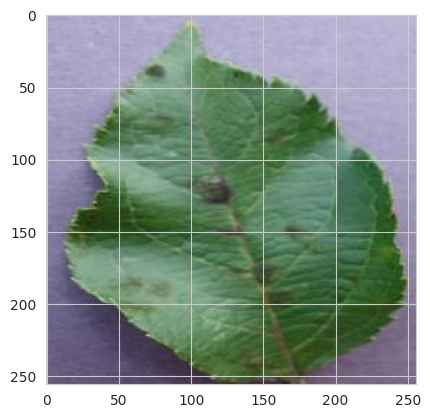

In [50]:
base_dir = '/content/data/plantvillage dataset/color'
img = mpimg.imread(f"{base_dir}/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG")
print(img.shape)
plt.imshow(img)
plt.show()


In [51]:
data='/content/data/plantvillage dataset/color'

def create_dataframe(data_path):
    # List to store filepaths and labels
    filepaths = []
    labels = []

    # List all subfolders in the current data path
    folds = os.listdir(data_path)

    # Iterate through each subfolder
    for fold in folds:
        f_path = os.path.join(data_path, fold)
        imgs = os.listdir(f_path)

        # Iterate through images in the subfolder
        for img in imgs:
            img_path = os.path.join(f_path, img)

            # Append image path and corresponding label
            filepaths.append(img_path)
            labels.append(fold)

    # Create Pandas Series for filepaths and labels
    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')

    # Concatenate into a DataFrame and return
    return pd.concat([fseries, lseries], axis=1)

# Create DataFrames for train, test, and val
df = create_dataframe(data)

In [52]:
df.head()

,Filepaths,Labels
0,/content/data/plantvillage dataset/color/Tomat...,Tomato___Spider_mites Two-spotted_spider_mite
1,/content/data/plantvillage dataset/color/Tomat...,Tomato___Spider_mites Two-spotted_spider_mite
2,/content/data/plantvillage dataset/color/Tomat...,Tomato___Spider_mites Two-spotted_spider_mite
3,/content/data/plantvillage dataset/color/Tomat...,Tomato___Spider_mites Two-spotted_spider_mite
4,/content/data/plantvillage dataset/color/Tomat...,Tomato___Spider_mites Two-spotted_spider_mite


# Splitting the dataset in train test and validation

In [53]:
# Split into train test and validation datasets
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 42)
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 42)

In [55]:
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Rescale pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)  # Only rescaling for validation and test
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 43444 validated image filenames belonging to 38 classes.
Found 5430 validated image filenames belonging to 38 classes.
Found 5431 validated image filenames belonging to 38 classes.


### Plotting the images

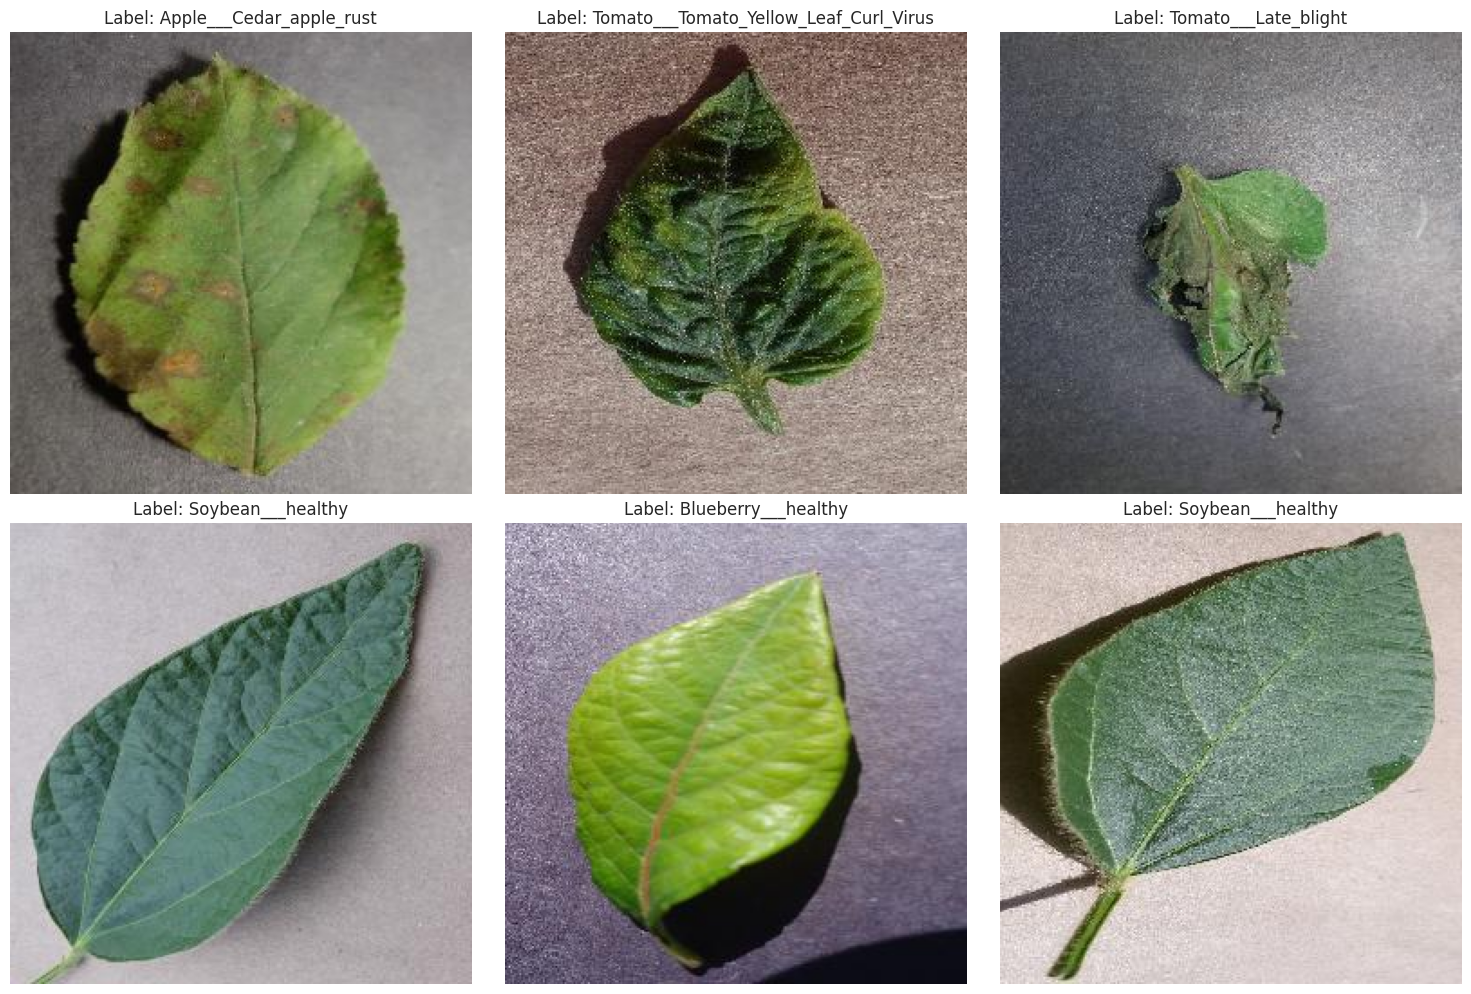

In [56]:
# Function to plot images with their labels
def plot_samples(df, num_samples=6):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Randomly select an image
        rand_idx = random.randint(0, len(df) - 1)
        img_path = df.iloc[rand_idx]['Filepaths']
        label = df.iloc[rand_idx]['Labels']

        # Read and plot the image
        img = plt.imread(img_path)
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f'Label: {label}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function to plot 6 random samples
plot_samples(train_df)


# Creating models

## Xception model

In [72]:
base_model = tf.keras.applications.xception.Xception(weights= 'imagenet' ,include_top = False , input_shape = (224,224,3) ,
                                                     pooling = 'max' )

xception_model = Sequential([
    base_model,
    BatchNormalization(),
    Dense(256,activation = 'relu'),
    Dropout(.5),
    Dense(38 , activation= 'softmax' )
])
xception_model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy' , metrics= ['accuracy'])
history = xception_model.fit(
    x= train_generator ,
    validation_data= valid_generator ,
    epochs= 5 , verbose = 1 ,
    validation_steps= None, shuffle= False
    )

Epoch 1/5
1358/1358 [==============================] - 7235s 5s/step - loss: 0.3585 - accuracy: 0.9024 - val_loss: 0.0629 - val_accuracy: 0.9792
Epoch 2/5
1358/1358 [==============================] - 7268s 5s/step - loss: 0.1104 - accuracy: 0.9688 - val_loss: 0.0429 - val_accuracy: 0.9880
Epoch 3/5
1358/1358 [==============================] - 7243s 5s/step - loss: 0.0722 - accuracy: 0.9797 - val_loss: 0.0256 - val_accuracy: 0.9910
Epoch 4/5
1358/1358 [==============================] - 7264s 5s/step - loss: 0.0534 - accuracy: 0.9857 - val_loss: 0.0365 - val_accuracy: 0.9901
Epoch 5/5
1358/1358 [==============================] - 7338s 5s/step - loss: 0.0453 - accuracy: 0.9875 - val_loss: 0.0185 - val_accuracy: 0.9950


In [73]:
xception_model.save('/content/drive/MyDrive/Projects/Plant Disease Detection/plant_disease_prediction_Xception_model.h5')

## Resnet

In [58]:
# ResNet model
resnet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model = Sequential([
    resnet_base_model,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(38, activation='softmax')
])
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

## Simple CNN Model

In [59]:
# Another simple model
another_model = Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(38, activation='softmax')
])
another_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


# Comparing Accuracies

In [60]:
def train_and_plot(model, train_generator, valid_generator, test_generator, epochs=3):
    history = model.fit(
        x=train_generator,
        validation_data=valid_generator,  # Use test_generator for evaluation
        epochs=epochs,
        verbose=1
    )
    test_loss, test_accuracy = model.evaluate(test_generator)
    print("Test Accuracy:", test_accuracy)

    tr_acc = history.history['accuracy']
    tr_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']

    epochs = [i+1 for i in range(len(tr_acc))]

    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, tr_loss, 'r', label='Train Loss')
    plt.plot(epochs, val_loss, 'g', label='Test Loss')  # Use Test Loss
    plt.title('Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, tr_acc, 'r', label='Train Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Test Accuracy')  # Use Test Accuracy
    plt.title('Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

    return model


Epoch 1/3
1358/1358 [==============================] - 976s 718ms/step - loss: 1.8312 - accuracy: 0.4876 - val_loss: 0.8907 - val_accuracy: 0.7280
Epoch 2/3
1358/1358 [==============================] - 970s 714ms/step - loss: 1.0357 - accuracy: 0.6850 - val_loss: 0.7576 - val_accuracy: 0.7659
Epoch 3/3
170/170 [==============================] - 29s 171ms/step - loss: 0.7764 - accuracy: 0.7722
Test Accuracy: 0.7722334861755371


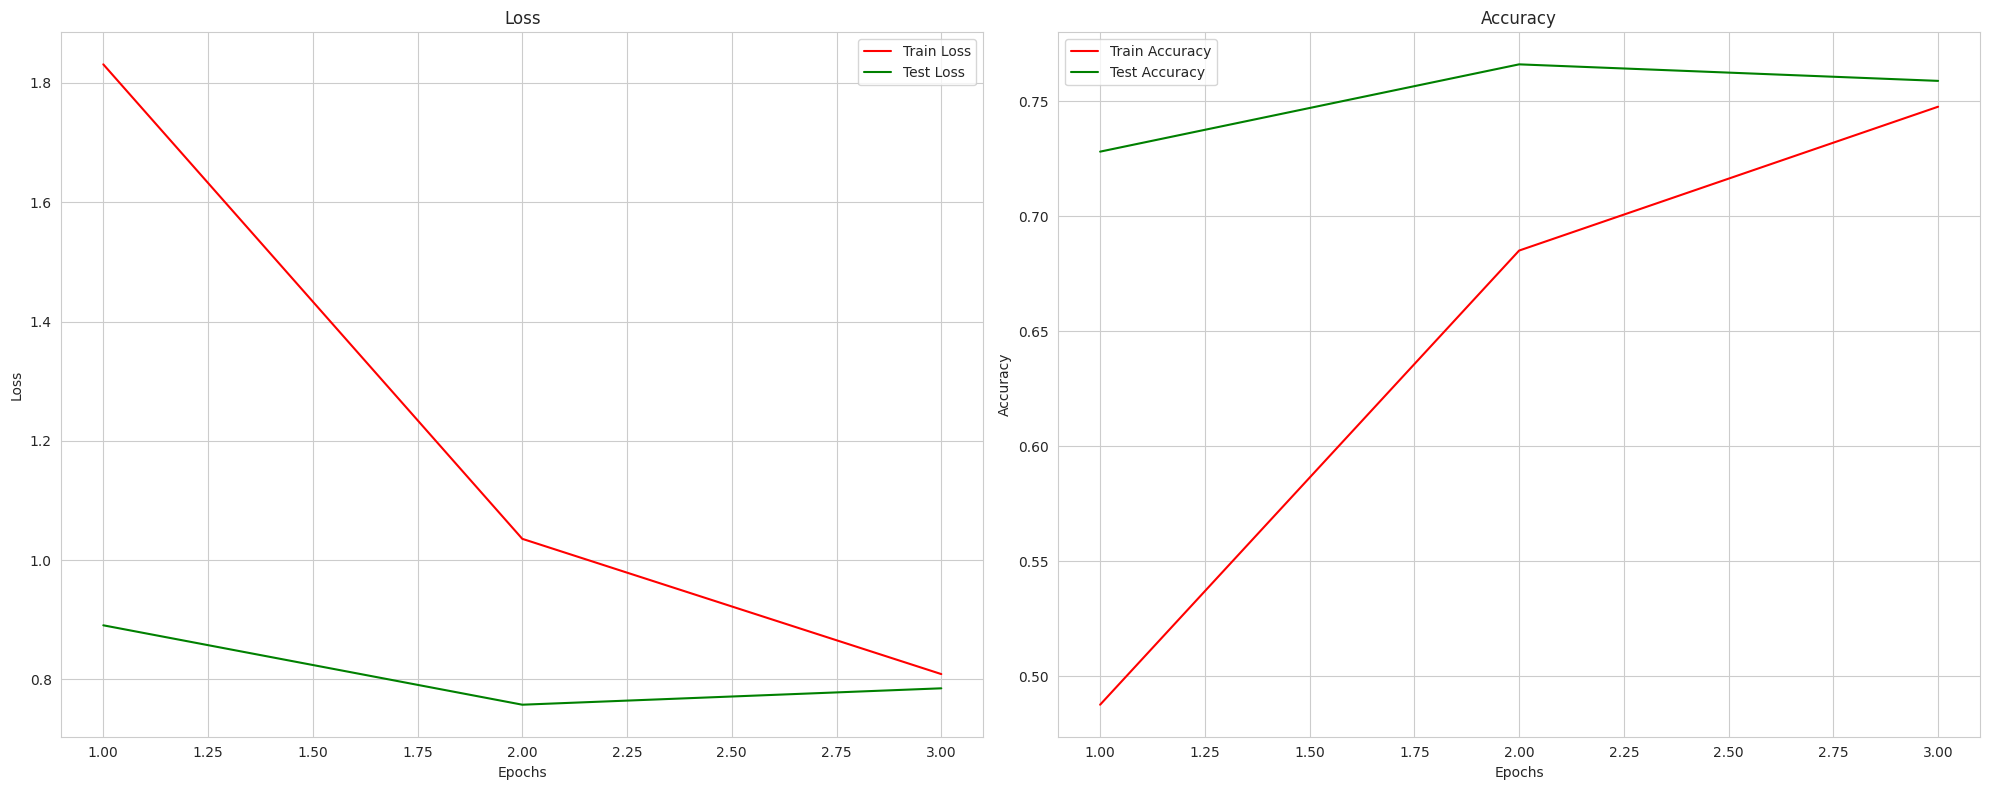

In [61]:
# train_and_plot(resnet_model, train_generator, valid_generator)
model = train_and_plot(another_model, train_generator, valid_generator, test_generator)

In [ ]:
model = train_and_plot(xception_model, train_generator, valid_generator, test_generator)

In [69]:
def load_and_preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    # Resize the image
    img = img.resize(target_size)
    # Convert the image to a numpy array
    img_array = np.array(img)
    # Add batch dimension
    img_array = np.expand_dims(img_array, axis=0)
    # Scale the image values to [0, 1]
    img_array = img_array.astype('float32') / 255.
    return img_array

def predict_image_class(model, image_path, class_indices):
    preprocessed_img = load_and_preprocess_image(image_path)
    predictions = model.predict(preprocessed_img)
    predicted_class_index = np.argmax(predictions, axis=1)[0]
    predicted_class_name = class_indices[predicted_class_index]
    return predicted_class_name


# Saving the model

In [62]:
class_indices = {v: k for k, v in train_generator.class_indices.items()}

In [63]:
class_indices

{0: 'Apple___Apple_scab',
 1: 'Apple___Black_rot',
 2: 'Apple___Cedar_apple_rust',
 3: 'Apple___healthy',
 4: 'Blueberry___healthy',
 5: 'Cherry_(including_sour)___Powdery_mildew',
 6: 'Cherry_(including_sour)___healthy',
 7: 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot',
 8: 'Corn_(maize)___Common_rust_',
 9: 'Corn_(maize)___Northern_Leaf_Blight',
 10: 'Corn_(maize)___healthy',
 11: 'Grape___Black_rot',
 12: 'Grape___Esca_(Black_Measles)',
 13: 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 14: 'Grape___healthy',
 15: 'Orange___Haunglongbing_(Citrus_greening)',
 16: 'Peach___Bacterial_spot',
 17: 'Peach___healthy',
 18: 'Pepper,_bell___Bacterial_spot',
 19: 'Pepper,_bell___healthy',
 20: 'Potato___Early_blight',
 21: 'Potato___Late_blight',
 22: 'Potato___healthy',
 23: 'Raspberry___healthy',
 24: 'Soybean___healthy',
 25: 'Squash___Powdery_mildew',
 26: 'Strawberry___Leaf_scorch',
 27: 'Strawberry___healthy',
 28: 'Tomato___Bacterial_spot',
 29: 'Tomato___Early_blight',
 30: '

In [64]:
# saving the class names as json file
json.dump(class_indices, open('class_indices.json', 'w'))

In [70]:
# Example Usage
image_path = '/content/data/plantvillage dataset/color/Apple___Apple_scab/00075aa8-d81a-4184-8541-b692b78d398a___FREC_Scab 3335.JPG'

predicted_class_name = predict_image_class(model, image_path, class_indices)

print("Predicted Class Name:", predicted_class_name)

1/1 [==============================] - 0s 87ms/step
Predicted Class Name: Apple___Apple_scab


In [71]:
model.save('/content/drive/MyDrive/Projects/Plant Disease Detection/plant_disease_prediction_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
